In [1]:
# Python Path non-sense
%load_ext autoreload
%autoreload 2

import sys
import os

# remove any paths that contains 'bayes_gsl' in the sys.path
sys.path = [x for x in sys.path if 'bayes_gsl' not in x]
new_path = '/Users/maxw/projects/gsl-bnn/'
if new_path not in sys.path:
    sys.path.append(new_path)

In [2]:
from scipy.spatial import distance_matrix
from sklearn.datasets import fetch_openml

import os
import pickle
import arviz
import matplotlib.pyplot as plt
import numpyro.infer
import seaborn as sns
from sklearn.calibration import calibration_curve
import numpy as np
from scipy.linalg import block_diag
import multiprocessing
import pandas as pd
import random
import time
import collections

### THIS MUST OCCUR BEFORE JAX IS IMPORTED ###
# for parallelization for multiple chains. Must be done before jax import:
# Blackjax tutorial: https://blackjax-devs.github.io/blackjax/examples/howto_sample_multiple_chains.html
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)
import jax 
import jax.numpy as jnp
from jax import random as jax_random
from jax.random import PRNGKey
print("Number of CPU cores:", jax.local_device_count()) # often will not allow multi-threading in Jupyter notebooks

import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import init_to_value
plt.style.use("bmh")
#from IPython.display import set_matplotlib_formats
import matplotlib_inline
if "NUMPYRO_SPHINXBUILS" in os.environ:
    #set_matplotlib_formats("svg")
    matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, autoguide

#sys.path.append('/content/bayes_gsl') # for colab

from src import TMLR_TEXTWIDTH, TMLR_PLOT_DEPTH, FIGURES_PATH, FINANCIAL_DATA_PATH, NUM_BINS

from src.models import dpg_bnn
#from src.data import load_data
from src.metrics import compute_metrics

from src.config import num_samples_to_generate, w_init_scale, lam_init_scale, altered_prior
from experiments.mnist.config import dpg_hyperparameters, experiment_settings
from src.utils import edge_density, adj2vec, vec2adj, degrees_from_upper_tri
from src.models import unroll_dpg, dpg_bnn

Number of CPU cores: 8


In [3]:
# Download the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, cache=True)
X, y = mnist['data'], mnist['target']
X_pd, y_pd = X, y
X, y = X.to_numpy(), y.to_numpy()


# all X's of same digit are adjacent
y = y.astype(int)
X = X[y.argsort()]
y = y[y.argsort()]

# Experiment 2: Digits 1 and 2

## Create Dataset

(10, 2, 25, 28, 28)
(50, 2, 25, 28, 28)
Distance vectorized shape: (10, 1225), Label Vectorized Shape (10, 1225), Num Nodes 50
label


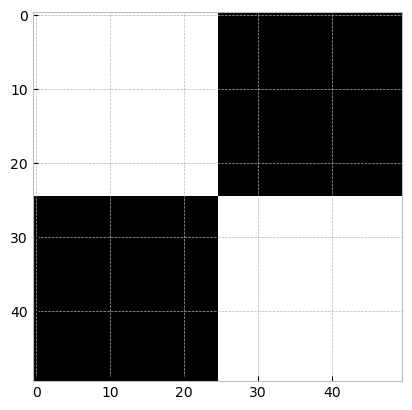

In [4]:
from sklearn.utils import shuffle
import numpy as np
from scipy.linalg import block_diag

num_samples = 10 # number of samples in the dataset
K = 25 # number of images per digit

# Function to sample K * num_samples of each digit without replacement
def sample_images(K, num_samples, X_train, y_train, random_state=42):
    samples = []
    for digit in range(10):
        if not(digit == 1 or digit == 2):
            continue

        # Get all images for the current digit
        digit_images = X_train[y_train == digit]
        
        # Shuffle and select K * num_samples images
        digit_images = shuffle(digit_images, random_state=random_state)[:K * num_samples]
        
        # Reshape to have num_samples groups of K images each
        samples.append(digit_images.reshape(num_samples, K, 28, 28))

        # sanity check: plot a few of the images
        """
        fig, axes = plt.subplots(1, K, figsize=(12, 6))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(samples[-1][0][i], cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.show()
        """
        

    # Convert to NumPy array and transpose to have shape (num_samples, 10, K, 28, 28)
    samples = np.array(samples).transpose(1, 0, 2, 3, 4)
    
    return samples

def create_label(K):
    # Create a list of these blocks
    blocks = [np.ones((K, K))] * (2)

    # Create the block diagonal matrix
    return block_diag(*blocks)


# construct train dataset
samples = sample_images(K, num_samples, X.reshape(-1, 28, 28), y)
print(samples.shape)  # Output should be (num_samples, num_digits, K, 28, 28)
distance_matrices = []
labels = []
for i in range(num_samples):
    e = distance_matrix(samples[i].reshape(-1, 28*28), samples[i].reshape(-1, 28*28))
    labels.append(create_label(K))
    distance_matrices.append(e)

# construct test dataset
test_samples = sample_images(K, num_samples*5, X.reshape(-1, 28, 28), y, random_state=100)
print(test_samples.shape)  # Output should be (num_samples, num_digits, K, 28, 28)
test_distance_matrices = []
test_labels = []
for i in range(num_samples):
    e = distance_matrix(test_samples[i].reshape(-1, 28*28), test_samples[i].reshape(-1, 28*28))
    test_labels.append(create_label(K))
    test_distance_matrices.append(e)

# convert distance matrices to vectors
distance_vecs = np.log10(adj2vec(jnp.array(distance_matrices))) - 3.0
label_vecs = adj2vec(jnp.array(labels))

test_distance_vecs = np.log10(adj2vec(jnp.array(test_distance_matrices))) - 3.0
test_label_vecs = adj2vec(jnp.array(test_labels))

# useful variables for later
n = distance_matrices[0].shape[-1]
num_edges = distance_vecs.shape[-1]
print(f"Distance vectorized shape: {distance_vecs.shape}, Label Vectorized Shape {label_vecs.shape}, Num Nodes {n}")

# sample label
print('label')
plt.imshow(labels[-1], cmap='gray')

## Visualize Euclidean Distance Data

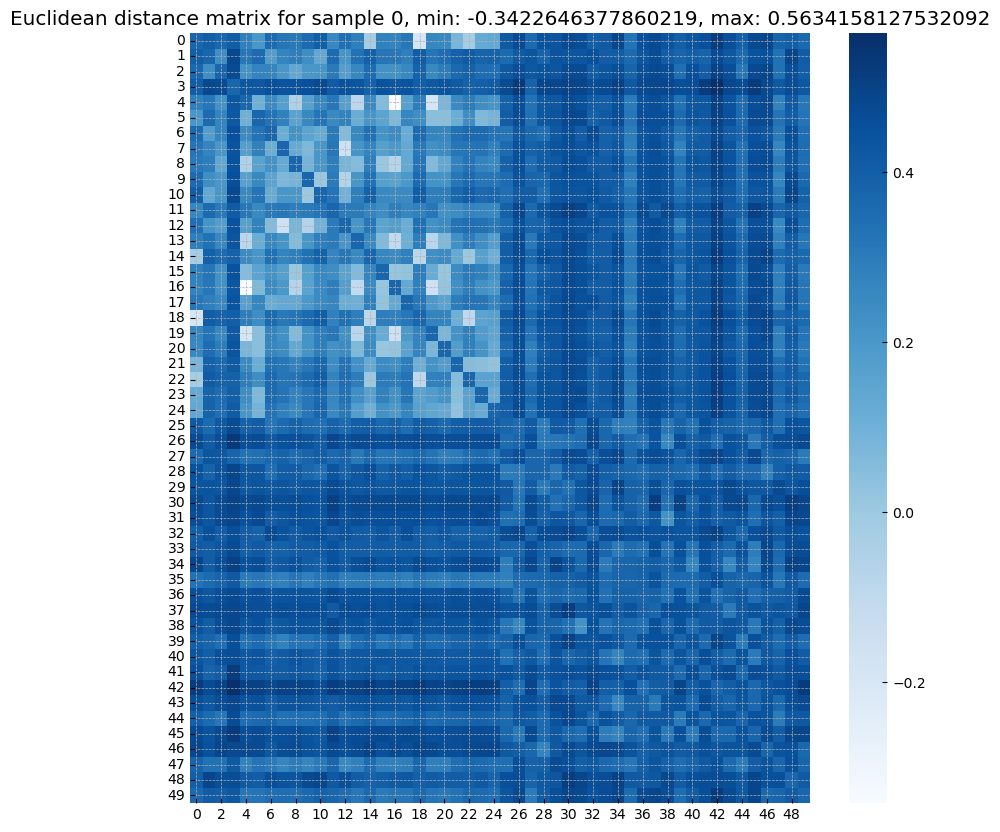

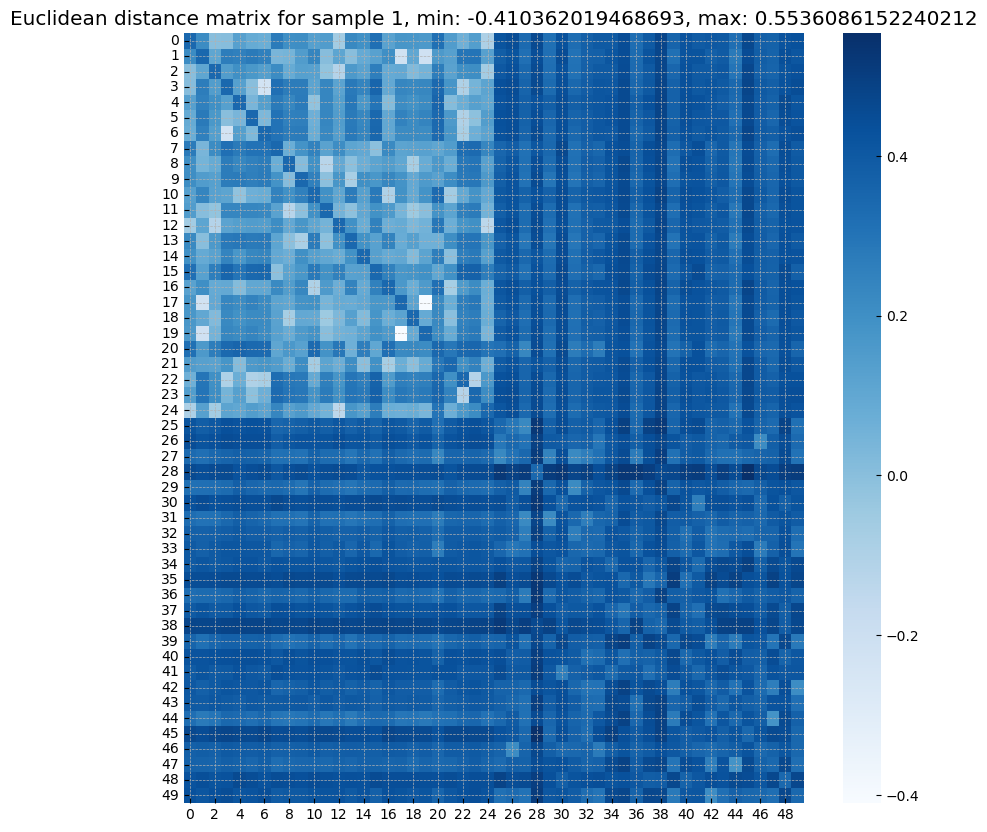

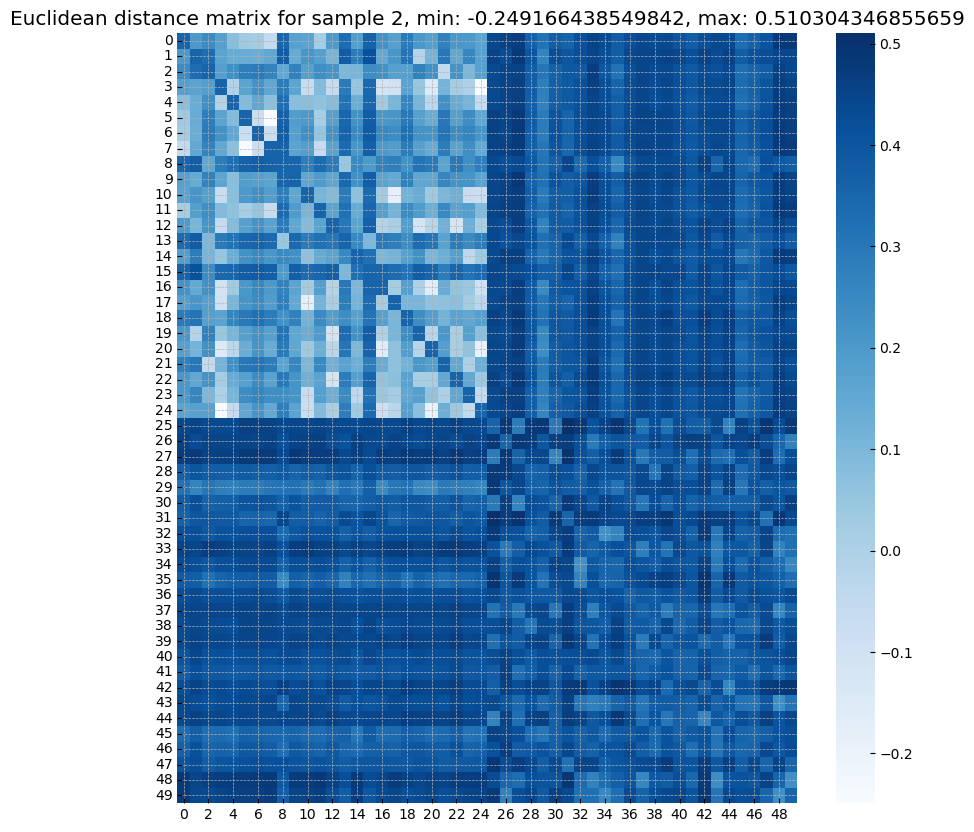

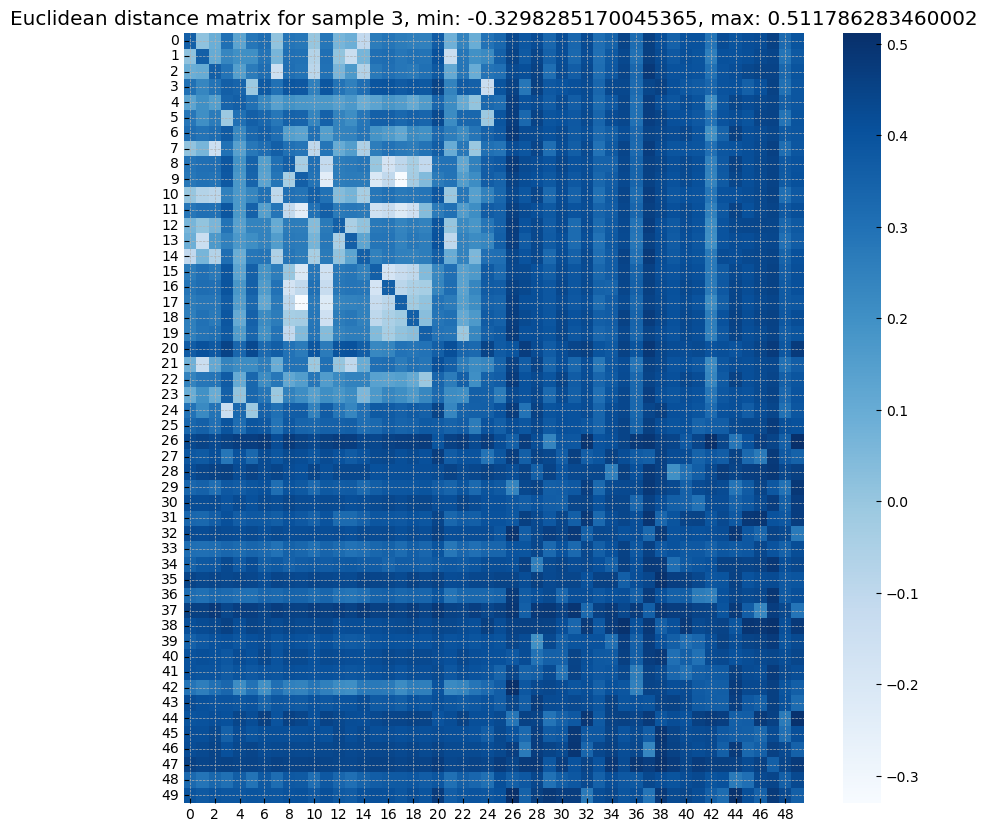

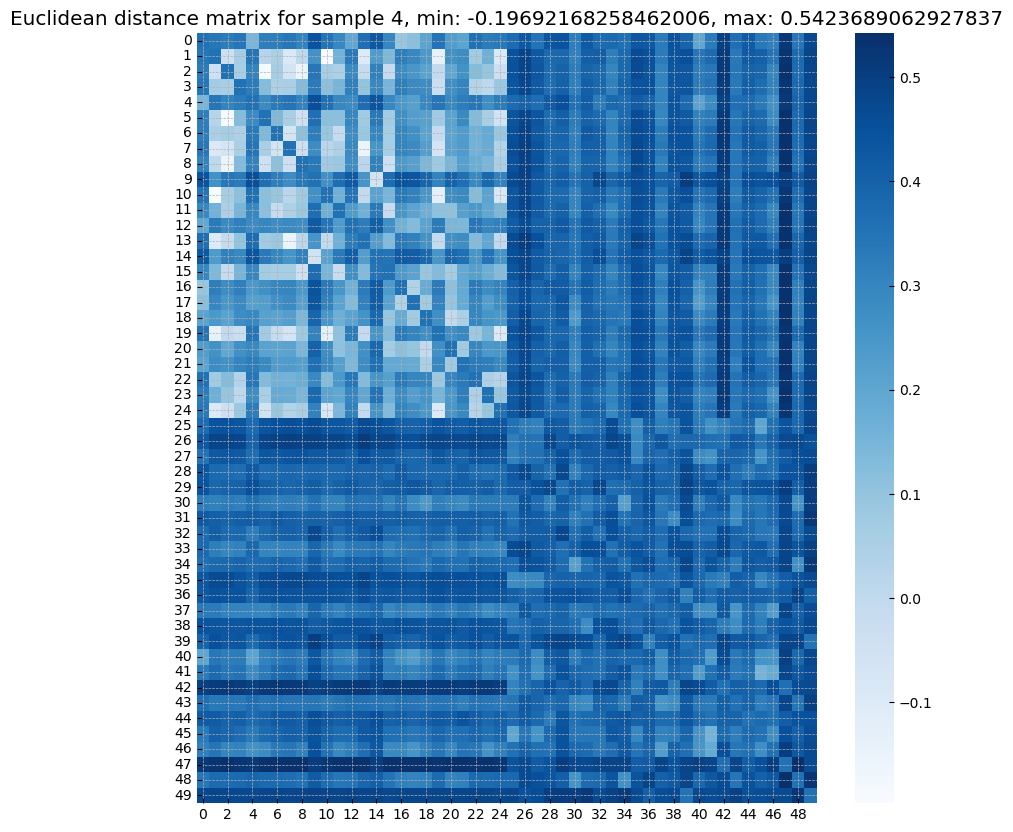

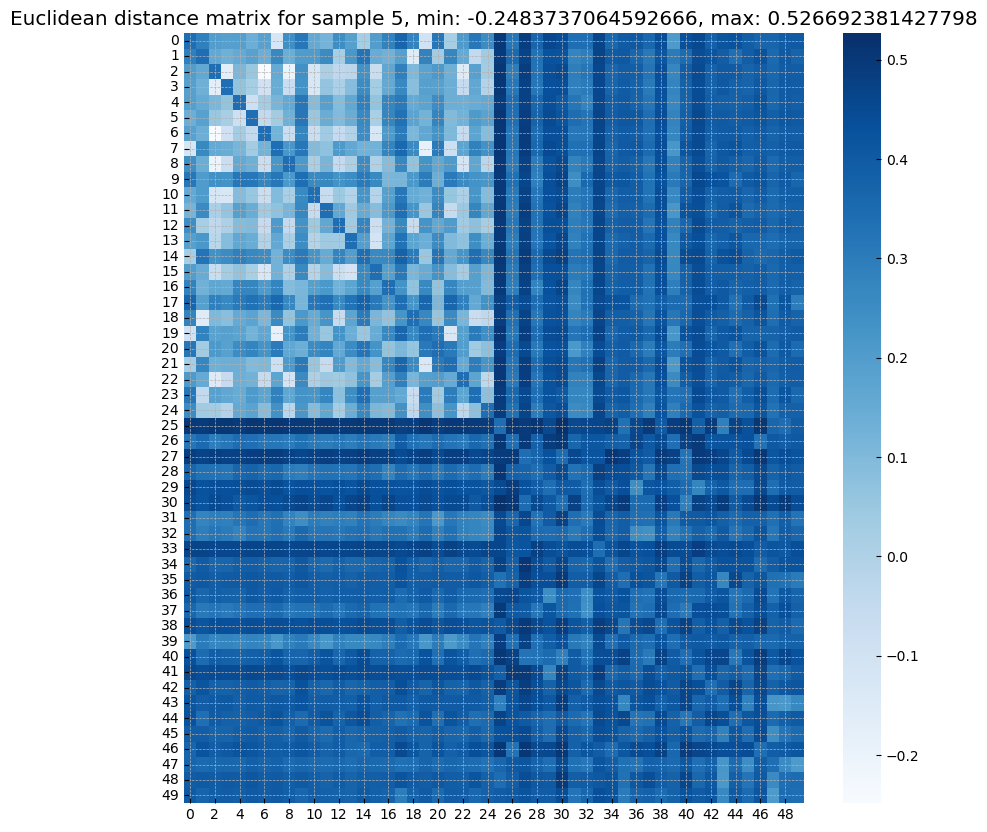

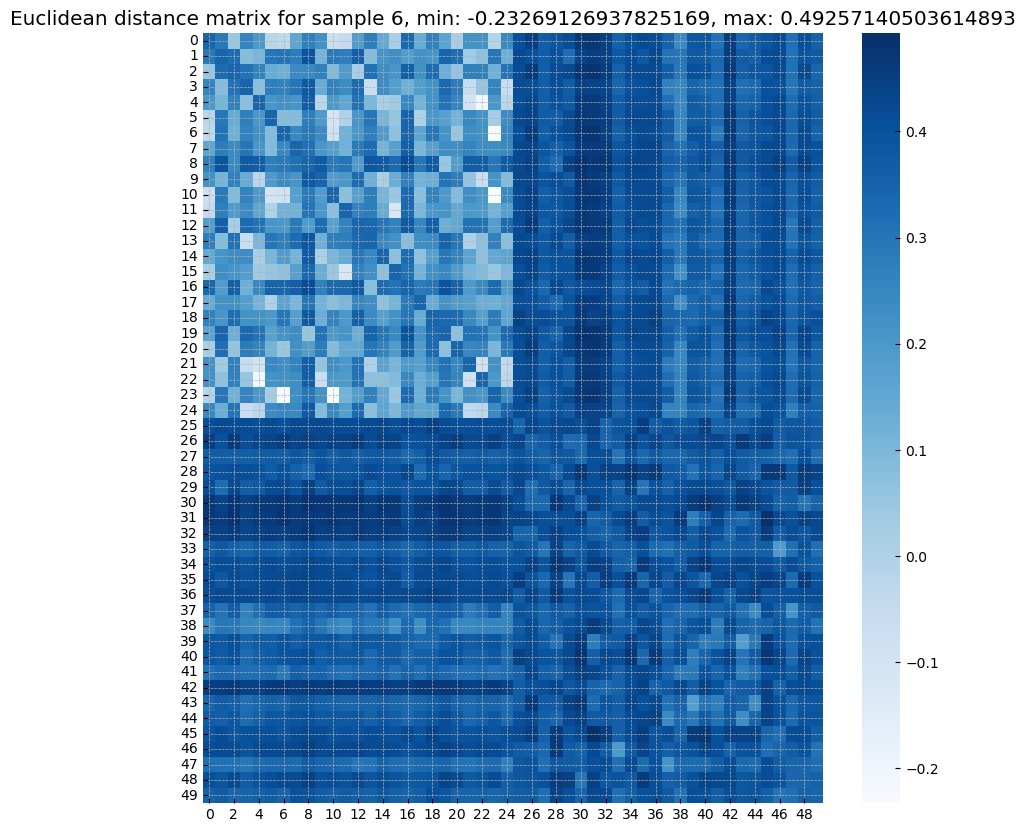

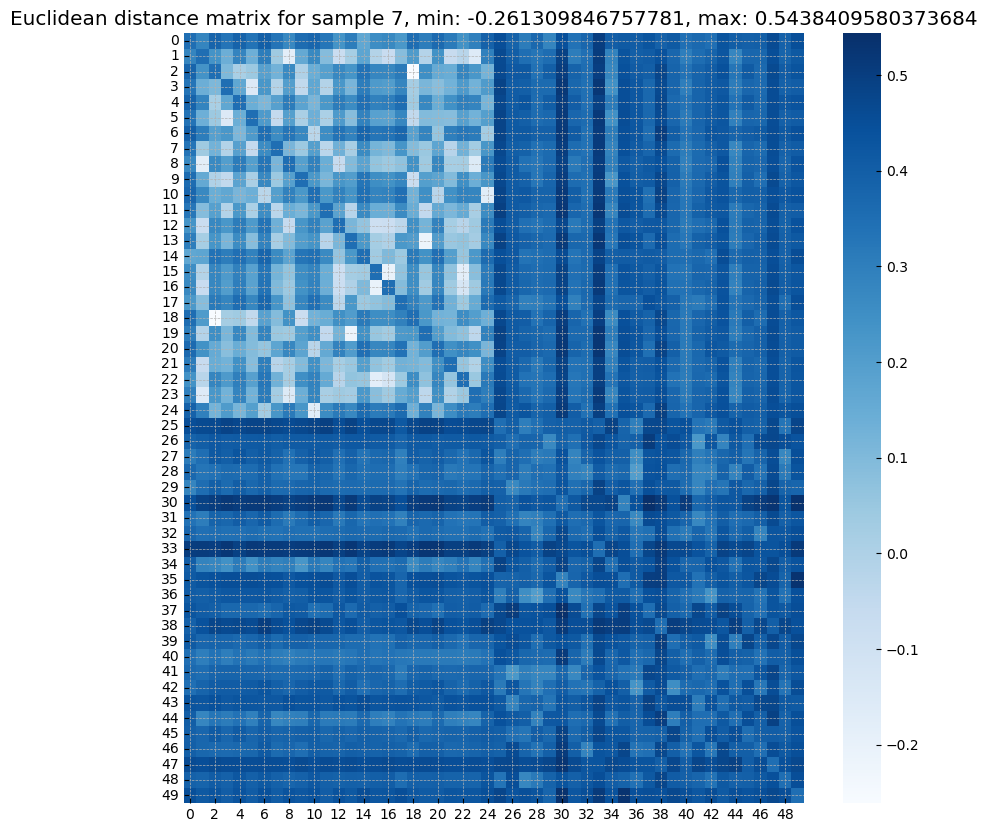

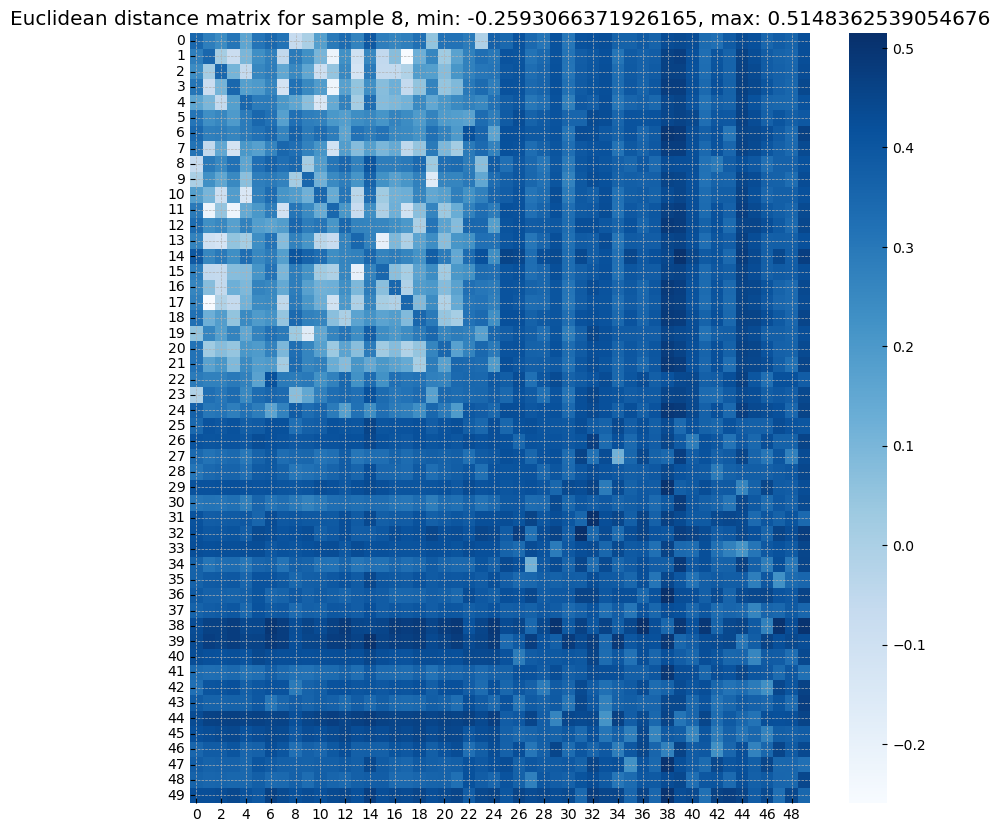

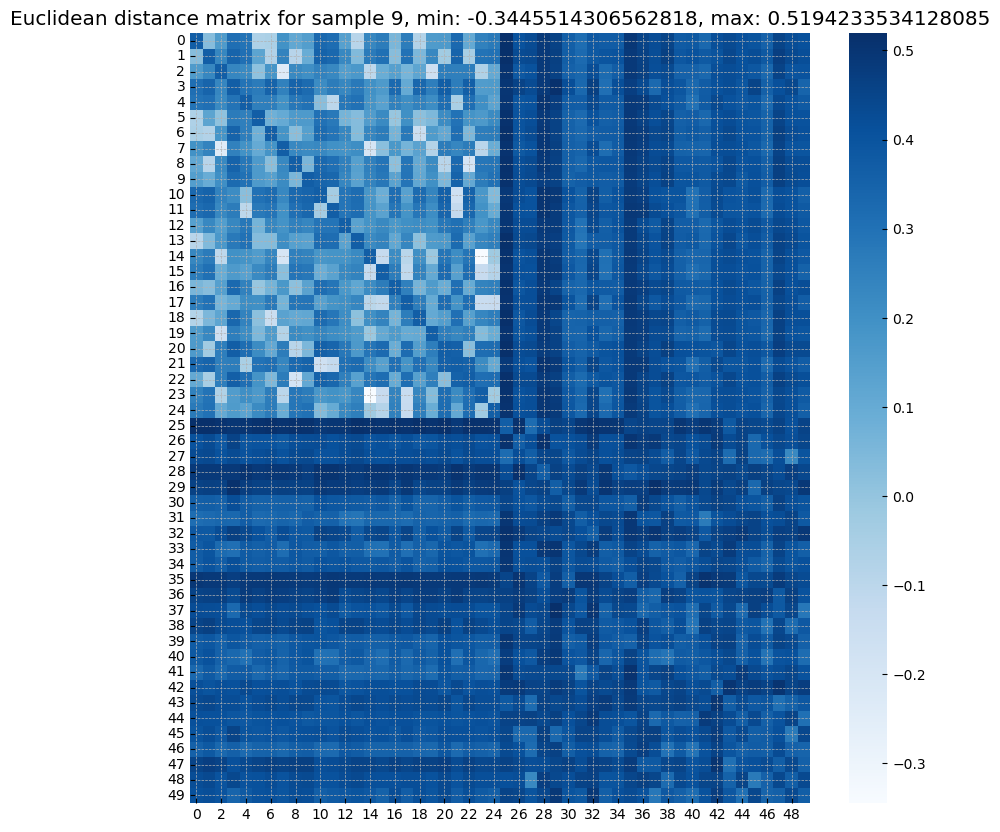

In [5]:
for i, e in enumerate(distance_matrices):
    plt.figure(figsize=(10, 10))

    # add to diagonal to avoid log(0)
    e += np.eye(e.shape[0]) * e.mean() # use mean instead of 0 to keep tight color range

    #sns.heatmap(np.log10(e)-3, cmap='Blues') # WITH ONES
    plotted_e = np.log10(e)-3
    sns.heatmap(plotted_e, cmap='Blues') # WITHOUT ONES

    plt.title(f'Euclidean distance matrix for sample {i}, min: {np.min(plotted_e)}, max: {np.max(plotted_e)}')
    plt.show()

## Prior Modeling: Find Performant \Theta with Convergent DPG Using Train Data

In [7]:
def calculate_scores(y_true, y_pred, eps=1e-3):
    # Ensure inputs are numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred > eps)
    assert y_true.shape == y_pred.shape, f'compute_scores recieved incompatible shapes'

    # true positive
    TP = np.sum((y_pred == 1) & (y_true == 1), axis=1)
    # true negatives
    TN = np.sum((y_pred == 0) & (y_true == 0), axis=1)
    # false positives
    FP = np.sum((y_pred == 1) & (y_true == 0), axis=1)
    # false negatives
    FN = np.sum((y_pred == 0) & (y_true == 1), axis=1)

    # false positive rate
    FPR = FP / (FP + TN)
    # false negative rate
    FNR = FN / (FN + TP)
    # precision
    precision = TP / (TP + FP)
    # recall
    recall = TP / (TP + FN)
    # F1 score
    F1 = 2 * ((precision * recall) / (precision + recall))
    # Error Rate
    error = (FP + FN) / (TP + FP + TN + FN)

    return FPR, FNR, F1, error

# run DPG to convergence for each graph size/theta pair
# define the search space for \theta: sample uniformly on a log scale from 100 to 4000
thetas = np.logspace(-.75, 2, 10)
depth = 2*10**4
threshold = 1e-3
performance = collections.defaultdict(dict)
solution = collections.defaultdict(dict)


a, e, = label_vecs, distance_vecs
w_init, lam_init = w_init_scale * jnp.ones((len(distance_vecs), num_edges)), lam_init_scale * jnp.ones((len(distance_vecs), n))
w, lam = None, None
S = jnp.array(degrees_from_upper_tri(n))

print(f"Shapes: a = {a.shape}, e = {e.shape}, w = {w_init.shape}, lam = {lam_init.shape}, S = {S.shape}")

for i, theta in enumerate(thetas):
    theta_start_time = time.time()
    print(f'\t{i+1}/{len(thetas)}: theta = {theta:.3f}')
    w, lam = unroll_dpg(
        x=e,
        w_init=w_init if w is None else w, # for convergence speed up: last convergent variables will be similar to the new
        lam_init=lam_init if lam is None else lam,
        theta=theta,
        num_steps=depth,
        S=S)
    FPR, FNR, F1, error = calculate_scores(a, w, eps=threshold)
    ed = edge_density(w>threshold)
    performance[theta] = {'FPR': FPR, 'FNR': FNR, 'F1': F1, 'error': error, 'edge_density': ed}
    solution[theta] = {'w': w, 'lam': lam}
    print(f'\t\ttime {time.time() - theta_start_time:.3f} | edge density {ed.mean()*100:.2f} %, error {error.mean()*100:.1f} %, F1 {F1.mean()*100:.3f} %, FPR {FPR.mean()*100:.3f} %, FNR {FNR.mean()*100:.3f} %')

Shapes: a = (10, 1225), e = (10, 1225), w = (10, 1225), lam = (10, 50), S = (50, 1225)
	1/10: theta = 0.178
		time 1.592 | edge density 100.00 %, error 51.0 %, F1 65.753 %, FPR 100.000 %, FNR 0.000 %
	2/10: theta = 0.359
		time 1.344 | edge density 100.00 %, error 51.0 %, F1 65.753 %, FPR 100.000 %, FNR 0.000 %
	3/10: theta = 0.726
		time 1.525 | edge density 92.52 %, error 43.6 %, F1 69.223 %, FPR 85.408 %, FNR 0.067 %
	4/10: theta = 1.468
		time 1.379 | edge density 42.15 %, error 20.9 %, F1 77.108 %, FPR 13.744 %, FNR 28.267 %
	5/10: theta = 2.966
		time 1.492 | edge density 18.73 %, error 32.3 %, F1 52.229 %, FPR 2.032 %, FNR 63.883 %
	6/10: theta = 5.995
		time 1.402 | edge density 9.40 %, error 39.9 %, F1 31.636 %, FPR 0.304 %, FNR 81.133 %
	7/10: theta = 12.115
		time 1.505 | edge density 6.38 %, error 42.8 %, F1 22.720 %, FPR 0.160 %, FNR 87.150 %
	8/10: theta = 24.484
		time 1.339 | edge density 5.18 %, error 43.9 %, F1 18.889 %, FPR 0.112 %, FNR 89.550 %
	9/10: theta = 49.482

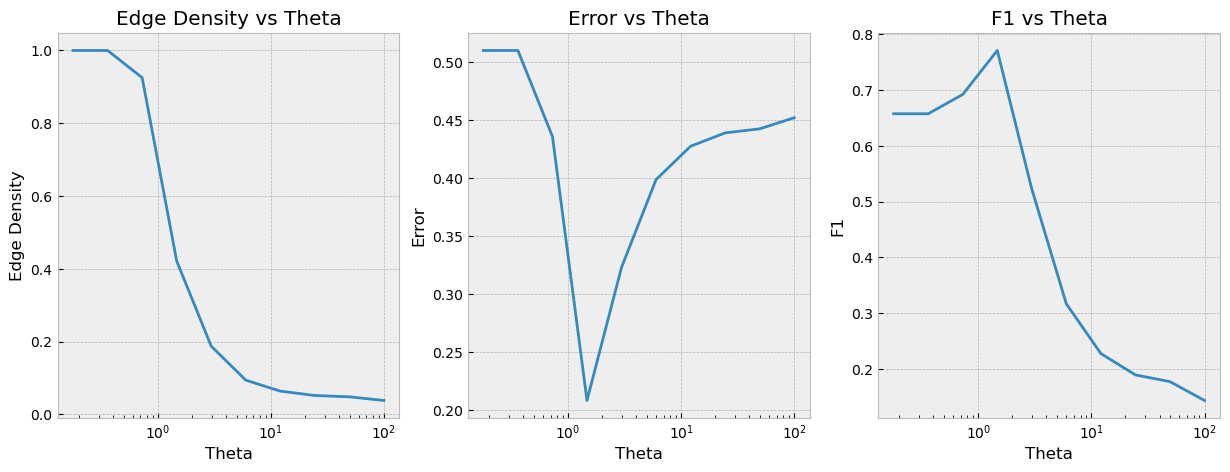

In [8]:
""" Plot edge density, error, F1 vs theta """
# plot edge density, error, F1 vs theta
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(thetas, [performance[theta]['edge_density'].mean() for theta in thetas])
axs[0].set_title('Edge Density vs Theta')
axs[0].set_xlabel('Theta')
axs[0].set_ylabel('Edge Density')
axs[1].plot(thetas, [performance[theta]['error'].mean() for theta in thetas])
axs[1].set_title('Error vs Theta')
axs[1].set_xlabel('Theta')
axs[1].set_ylabel('Error')
#axs[2].plot(thetas, [performance[theta]['F1'].mean() for theta in the thetas])
axs[2].plot(thetas, [performance[theta]['F1'].mean() for theta in thetas])
axs[2].set_title('F1 vs Theta')
axs[2].set_xlabel('Theta')
axs[2].set_ylabel('F1')

# set log scale for theta
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')

plt.show()

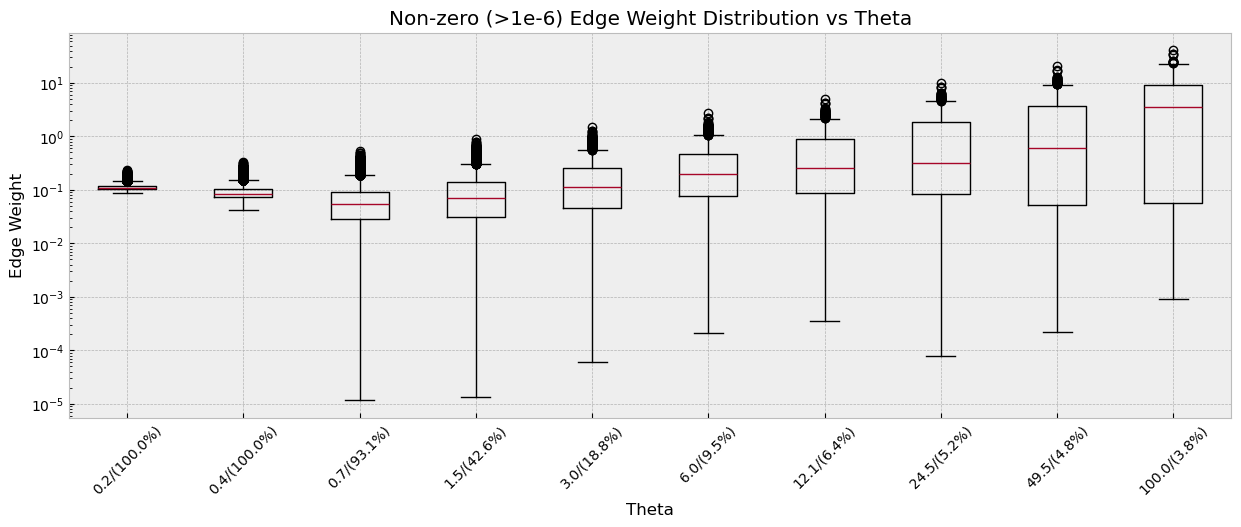

In [9]:
""" Plot the edge weight distribution for each theta. Each theta should have a box and whisker plot. """
# edge weights are stores in solution[theta]['w']

import matplotlib.pyplot as plt
import numpy as np

# extract the edge weights for each theta
edge_weights = {theta: solution[theta]['w'] for theta in thetas}

# create box and whisker plot with min, max, median, and quartiles for edge weights at each theta. This should all be done on the same plot.
fig, ax = plt.subplots(figsize=(15, 5))
ax.boxplot([edge_weights[theta].flatten()[edge_weights[theta].flatten() > 1e-6] for theta in thetas], labels=[f'{theta:.3f}' for theta in thetas])
# set xticklabels to be the rounded theta values. Rotate the labels 45 degrees.
# % of non-zero edge weights for each theta
percent_non_zero = [100*(edge_weights[theta].flatten() > 1e-6).mean() for theta in thetas]
ax.set_xticklabels([f'{theta:.1f}/({percent_non_zero[i]:.1f}%)' for i, theta in enumerate(thetas)], rotation=45)
ax.set_title('Non-zero (>1e-6) Edge Weight Distribution vs Theta')
ax.set_xlabel('Theta')
ax.set_ylabel('Edge Weight')
ax.set_yscale('log')
plt.show()

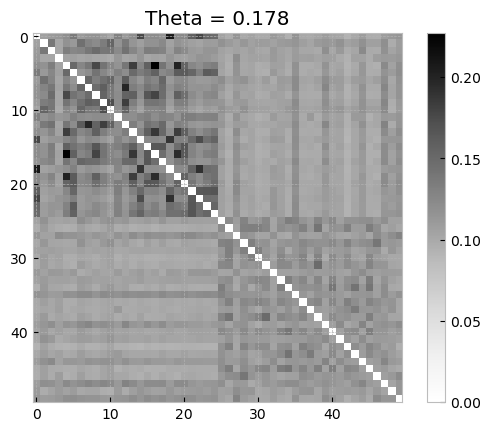

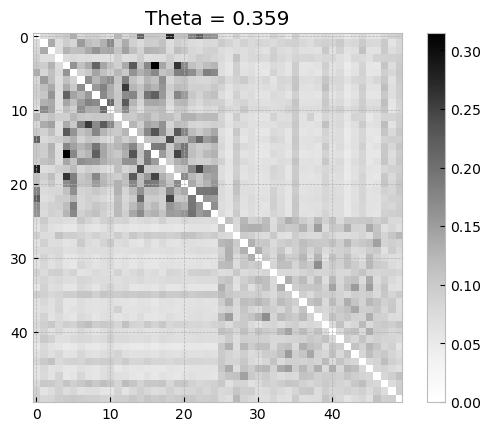

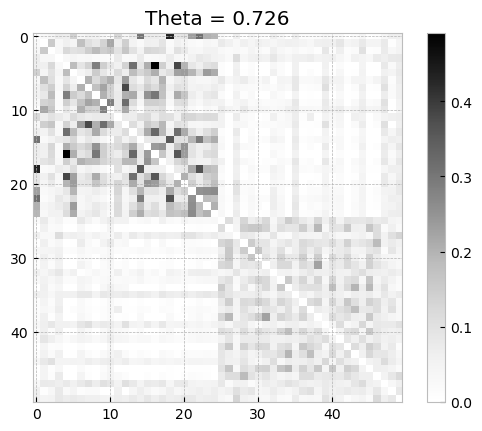

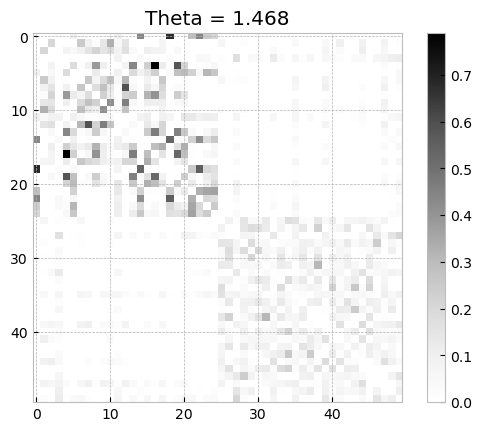

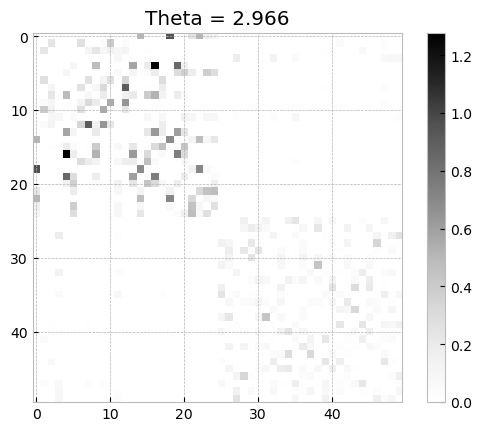

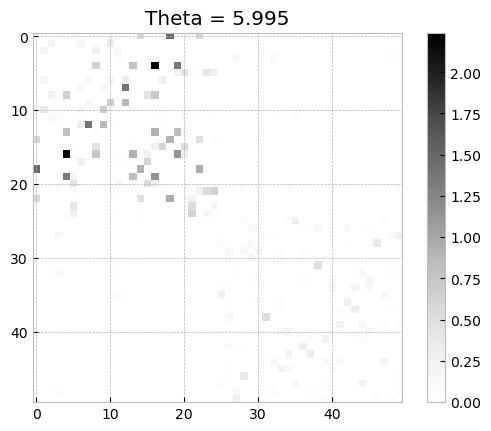

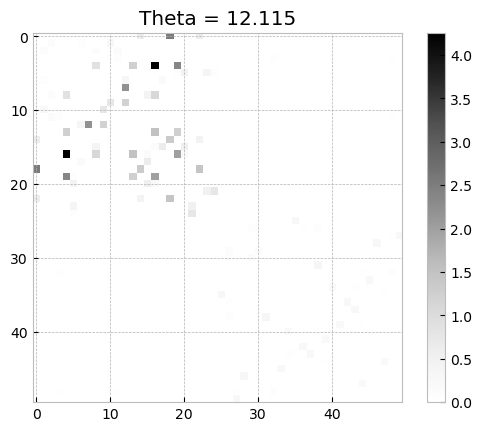

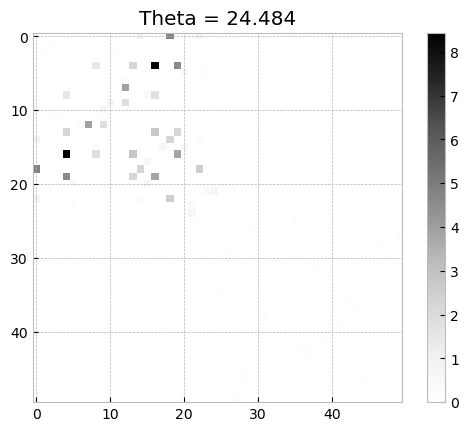

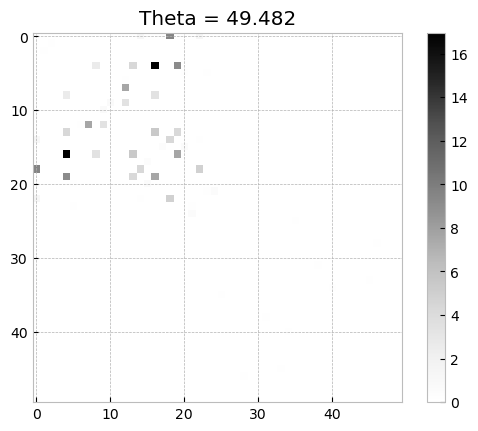

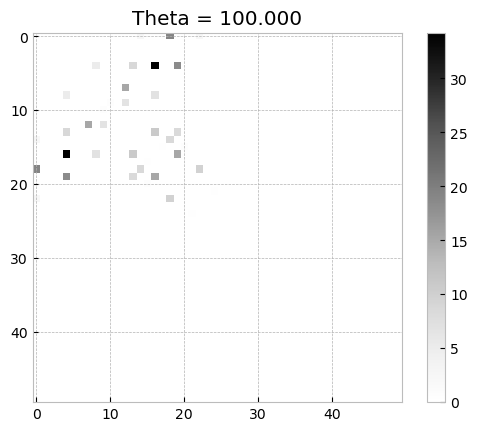

In [10]:
for theta in thetas:
    s = solution[theta]['w']
    s = vec2adj(s, n=n)[0]
    plt.imshow(s, cmap='Greys')
    plt.title(f'Theta = {theta:.3f}')
    plt.colorbar()
    plt.show()

## Run Bayesian Parameter Inference

In [11]:
### configure model
model_args = \
    {'x': distance_vecs, 'y': label_vecs,
     'depth': dpg_hyperparameters['depth'], 
     'w_init': w_init_scale * jnp.ones((len(distance_vecs), num_edges)), 'lam_init': lam_init_scale * jnp.ones((len(distance_vecs), n)),
     'S': S,
     'prior_settings': dpg_hyperparameters['prior']} # priors for model parameters

test_model_args = \
    {'x': test_distance_vecs, 'y': test_label_vecs,
    'depth': dpg_hyperparameters['depth'],
    'w_init': w_init_scale * jnp.ones((len(test_distance_vecs), num_edges)), 'lam_init': lam_init_scale * jnp.ones((len(test_distance_vecs), n)),
    'S': S,
    'prior_settings': dpg_hyperparameters['prior']}

In [12]:
#w_test, lam_test = jnp.squeeze(w_init), jnp.squeeze(lam_init)
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = jax.random.PRNGKey(0)
rng_key, rng_key_ = jax.random.split(rng_key)

model = dpg_bnn.model
kernel = NUTS(model, forward_mode_differentiation=True)
mcmc = MCMC(kernel,
            num_warmup=experiment_settings['num_warmup_samples'], num_samples=experiment_settings['num_posterior_samples'],
            progress_bar=True,
            num_chains=experiment_settings['num_chains'], chain_method='parallel')
start_time = time.time()
mcmc.run(rng_key_, **model_args)
end_time = time.time()
print(f"Time taken for inference using {experiment_settings['num_chains']} with {experiment_settings['num_warmup_samples']} warmup samples and {experiment_settings['num_posterior_samples']} samples: {end_time - start_time}")
mcmc.print_summary()
print(f"^^********** Finished  **********^^\n\n")
samples = mcmc.get_samples()

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Time taken for inference using 4 with 500 warmup samples and 1000 samples: 1840.6699821949005

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      3.07      0.09      3.06      2.92      3.22   1073.92      1.00
     delta     55.59      1.22     55.56     53.69     57.71   1139.32      1.00
     theta      0.72      0.01      0.72      0.71      0.74   1240.54      1.00

Number of divergences: 0
^^********** Finished  **********^^




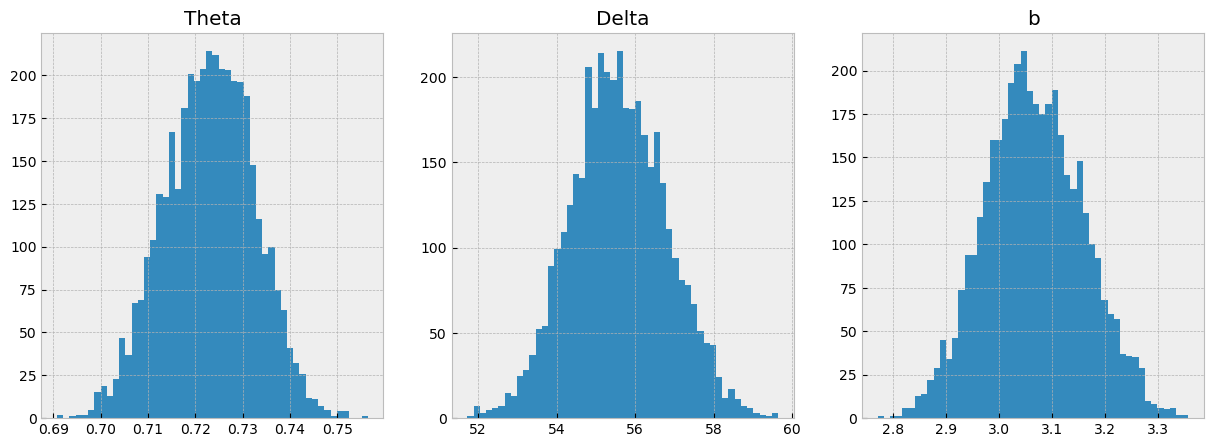

In [13]:
# visualize the posterior sample distributions
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(samples['theta'].reshape(-1,), bins=50)
axs[0].set_title('Theta')
axs[1].hist(samples['delta'].reshape(-1,), bins=50)
axs[1].set_title('Delta')
axs[2].hist(samples['b'].reshape(-1,), bins=50)
axs[2].set_title('b')
plt.show()


## Save/Load Posterior Samples and Data

In [14]:
# FIRST TWO CELLS MUST BE RUN BEFORE THIS
results_path = experiment_settings['results_path'] + 'samples_and_data.pkl'

In [17]:
samples_path = experiment_settings['results_path'] + 'samples.pkl'
with open(samples_path, 'wb') as f:
    pickle.dump({'samples': samples}, f)

In [18]:
data_path = experiment_settings['results_path'] + 'data.pkl'
with open(data_path, 'wb') as f:
    pickle.dump({'distance_vecs': distance_vecs, 
                 'test_distance_vecs': test_distance_vecs, 
                 'label_vecs': label_vecs, 
                 'test_label_vecs': test_label_vecs,
                 'model_args': model_args,
                 'test_model_args': test_model_args}, f)

In [19]:
edge_logits = dpg_bnn.forward_pass_vmap()(samples['theta'], samples['delta'], samples['b'],
                                          model_args['x'], 
                                          model_args['w_init'], 
                                          model_args['lam_init'], 
                                          model_args['depth'], 
                                          model_args['S']
                                          )
edge_logits = jnp.squeeze(edge_logits)

test_edge_logits = dpg_bnn.forward_pass_vmap()(samples['theta'], samples['delta'], samples['b'],
                                               test_model_args['x'], 
                                               test_model_args['w_init'], 
                                               test_model_args['lam_init'],
                                               test_model_args['depth'], 
                                               test_model_args['S']
                                               )
test_edge_logits = jnp.squeeze(test_edge_logits)

print(f"Edge logits shape: {edge_logits.shape}, test edge logits shape: {test_edge_logits.shape}")

Edge logits shape: (4000, 10, 1225), test edge logits shape: (4000, 10, 1225)


## Evaluation and Display

In [20]:
def plot_results(label, input, edge_logits, n):
    print(f"Label {label.shape}, Input {input.shape}, Edge logits {edge_logits.shape}")
    edge_probs = jax.nn.sigmoid(edge_logits)
    
    mean_edge_probs = edge_probs.mean(axis=0, keepdims=False)
    std_edge_probs = edge_probs.std(axis=0, keepdims=False)
    mean_edge_probs_adj = vec2adj(mean_edge_probs, n=n).squeeze()
    std_edge_probs_adj = vec2adj(std_edge_probs, n=n).squeeze()
    labels_adj = vec2adj(label, n=n).squeeze()
    inputs_adj = vec2adj(input, n=n).squeeze()

    # plot label, mean, and std
    fig, axs = plt.subplots(len(mean_edge_probs), 4, figsize=(15, 5))
    
    # Turn off tick labels and adjust spacing
    #for ax in axs:
        #ax.set_xticks([])
        #ax.set_yticks([])
    axs[0, 0].set_title('Label')
    axs[0, 1].set_title('Input')
    axs[0, 2].set_title('Mean')
    axs[0, 3].set_title('Std')
    print(f"Will iterate over {len(mean_edge_probs)} samples")
    for i in range(len(mean_edge_probs)):

        axs[i, 0].imshow(labels_adj[i], cmap='gray')
        axs[i, 1].imshow(inputs_adj[i], cmap='gray')
        axs[i, 2].imshow(mean_edge_probs_adj[i], cmap='gray')
        axs[i, 3].imshow(std_edge_probs_adj[i], cmap='gray')
    
    # remove the x and y ticks
    for ax in axs.flat:
        ax.set(xticks=[], yticks=[])

    
    # Reduce space between plots
    #plt.tight_layout()
    # the space between the plots is still very large (horizontally). Fix this.
    plt.subplots_adjust(wspace=0.0, hspace=0.0)

    plt.show()

Label (10, 1225), Input (10, 1225), Edge logits (4000, 10, 1225)
Will iterate over 10 samples


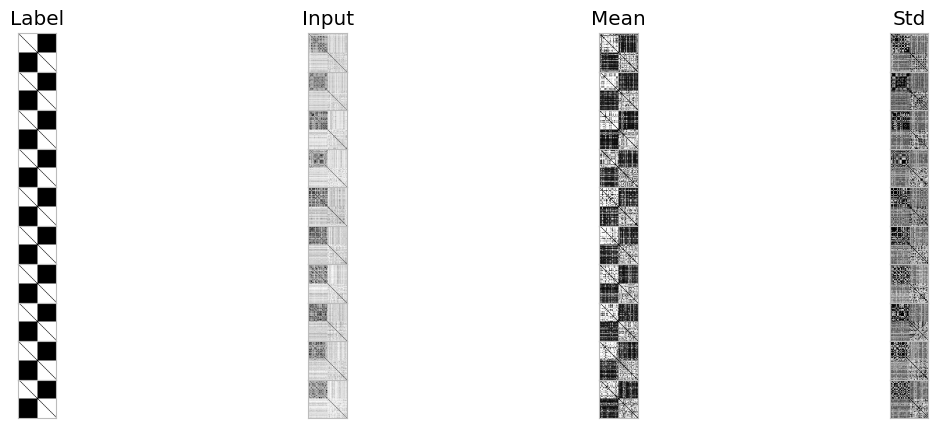

Label (10, 1225), Input (10, 1225), Edge logits (4000, 10, 1225)
Will iterate over 10 samples


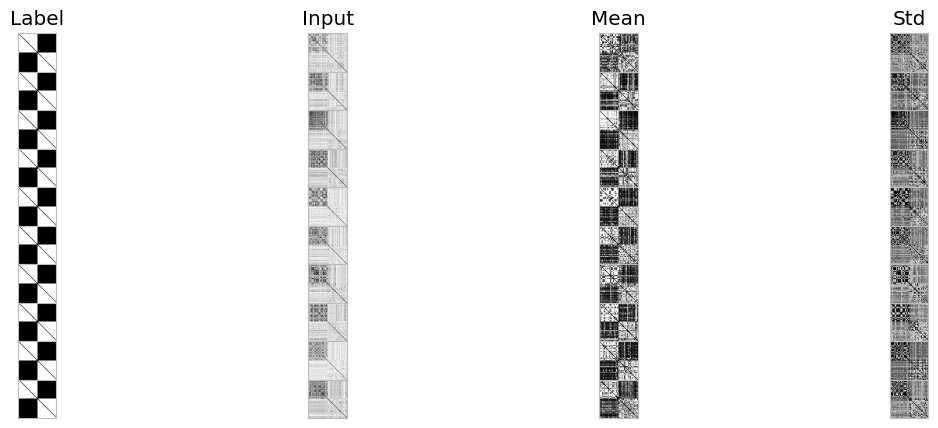

In [21]:
# on test set
plot_results(label_vecs, distance_vecs, edge_logits, n)
plot_results(test_label_vecs, test_distance_vecs, test_edge_logits, n)

Label (10, 1225), Input (10, 1225), Edge logits (4000, 10, 1225)


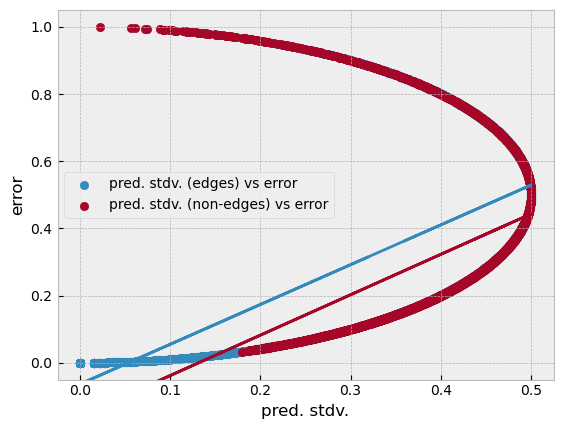

Correlation between error and uncertainty (l1): 0.6194069703818108
Correlation between error and uncertainty (l1) (pos): 0.7193331572572796
Correlation between error and uncertainty (l1) (neg): 0.5090746740453506


In [28]:
def uncertainty_quantification(label, input, edge_logits):
    print(f"Label {label.shape}, Input {input.shape}, Edge logits {edge_logits.shape}")
    edge_probs = jax.nn.sigmoid(edge_logits)
    
        # draw samples from the posterior preditive
        posterior_predictive_edge_samples = jax.random.bernoulli(jax.random.PRNGKey(0), edge_probs) + 0.0
        mean_edge_marginal_post_pred_estimate = np.array(posterior_predictive_edge_samples.mean(axis=0))
        std_edge_marginal_post_pred_estimate = np.array(posterior_predictive_edge_samples.std(axis=0))
        # add trailing dimension to mean and std
        mean_edge_marginal_post_pred_estimate = np.expand_dims(mean_edge_marginal_post_pred_estimate, 0)
        std_edge_marginal_post_pred_estimate = np.expand_dims(std_edge_marginal_post_pred_estimate, 0)
        error_l1 = np.abs(mean_edge_marginal_post_pred_estimate - label)
        #  add a leading singleton dimension to label
        label = jnp.expand_dims(label, 0)
        pos_error_l1 = error_l1[label == 1]
        neg_error_l1 = error_l1[label == 0]
        pos_uncertainty = std_edge_marginal_post_pred_estimate[label == 1]
        neg_uncertainty = std_edge_marginal_post_pred_estimate[label == 0]

        mean_plot = mean_edge_marginal_post_pred_estimate
        std_plot = std_edge_marginal_post_pred_estimate
        mean_adj_plot = vec2adj(mean_edge_marginal_post_pred_estimate.squeeze(), n=n).squeeze()
        std_adj_plot = vec2adj(std_edge_marginal_post_pred_estimate.squeeze(), n=n).squeeze()
    """ 
    mean_edge_probs = edge_probs.mean(axis=0, keepdims=False)
    std_edge_probs = edge_probs.std(axis=0, keepdims=False)

    # compute error
    error_l1 = np.abs(mean_edge_probs - label)

    # find the error_l1 for positive and negative edges
    pos_error_l1 = error_l1[label == 1]
    neg_error_l1 = error_l1[label == 0]

    # find the uncertainty for positive and negative edges
    pos_uncertainty = std_edge_probs[label == 1]/jnp.max(std_edge_probs)
    neg_uncertainty = std_edge_probs[label == 0]/jnp.max(std_edge_probs)

    """
    # plot the error vs uncertainty for positive and negative edges
    plt.scatter(pos_uncertainty, pos_error_l1, label='pred. stdv. (edges) vs error')
    plt.scatter(neg_uncertainty, neg_error_l1, label='pred. stdv. (non-edges) vs error')
    
    # fit a line to each and plot
    pos_fit_line = np.polyfit(pos_uncertainty, pos_error_l1, 1)
    neg_fit_line = np.polyfit(neg_uncertainty, neg_error_l1, 1)
    plt.plot(pos_uncertainty, pos_fit_line[0] * pos_uncertainty + pos_fit_line[1]) #, label='fit line (pos)')
    plt.plot(neg_uncertainty, neg_fit_line[0] * neg_uncertainty + neg_fit_line[1]) #, label='fit line (neg)')
    plt.ylim(-0.05, 1.05)

    plt.legend()
    plt.xlabel('pred. stdv.')
    plt.ylabel('error')
    plt.show()

    # measure the correlation between error and uncertainty
    print(f"Correlation between error and uncertainty (l1): {np.corrcoef(error_l1.reshape(-1), std_plot.reshape(-1))[0, 1]}")
    print(f"Correlation between error and uncertainty (l1) (pos): {np.corrcoef(pos_error_l1.reshape(-1), pos_uncertainty.reshape(-1))[0, 1]}")
    print(f"Correlation between error and uncertainty (l1) (neg): {np.corrcoef(neg_error_l1.reshape(-1), neg_uncertainty.reshape(-1))[0, 1]}")

uncertainty_quantification(test_label_vecs, test_distance_vecs, test_edge_logits, n)

Label (10, 1225), Input (10, 1225), Edge logits (4000, 10, 1225)


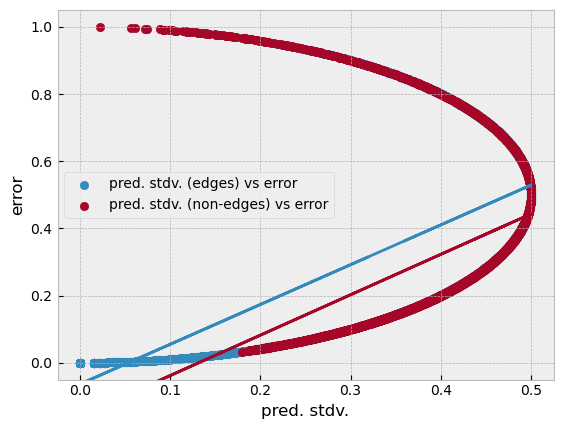

Correlation between error and uncertainty (l1): 0.6194069703818108
Correlation between error and uncertainty (l1) (pos): 0.7193331572572796
Correlation between error and uncertainty (l1) (neg): 0.5090746740453506


In [39]:
def uncertainty_quantification(label, input, edge_logits, n):
    print(f"Label {label.shape}, Input {input.shape}, Edge logits {edge_logits.shape}")
    edge_probs = jax.nn.sigmoid(edge_logits)
    
    # draw samples from the posterior preditive
    posterior_predictive_edge_samples = jax.random.bernoulli(jax.random.PRNGKey(0), edge_probs) + 0.0
    mean_edge_marginal_post_pred_estimate = np.array(posterior_predictive_edge_samples.mean(axis=0))
    std_edge_marginal_post_pred_estimate = np.array(posterior_predictive_edge_samples.std(axis=0))
    # add trailing dimension to mean and std
    mean_edge_marginal_post_pred_estimate = np.expand_dims(mean_edge_marginal_post_pred_estimate, 0)
    std_edge_marginal_post_pred_estimate = np.expand_dims(std_edge_marginal_post_pred_estimate, 0)
    error_l1 = np.abs(mean_edge_marginal_post_pred_estimate - label)
    #  add a leading singleton dimension to label
    label = jnp.expand_dims(label, 0)
    pos_error_l1 = error_l1[label == 1]
    neg_error_l1 = error_l1[label == 0]
    pos_uncertainty = std_edge_marginal_post_pred_estimate[label == 1]
    neg_uncertainty = std_edge_marginal_post_pred_estimate[label == 0]

    mean_plot = mean_edge_marginal_post_pred_estimate
    std_plot = std_edge_marginal_post_pred_estimate
    mean_adj_plot = vec2adj(mean_edge_marginal_post_pred_estimate.squeeze(), n=n).squeeze()
    std_adj_plot = vec2adj(std_edge_marginal_post_pred_estimate.squeeze(), n=n).squeeze()

    # plot the error vs uncertainty for positive and negative edges
    plt.scatter(pos_uncertainty, pos_error_l1, label='pred. stdv. (edges) vs error')
    plt.scatter(neg_uncertainty, neg_error_l1, label='pred. stdv. (non-edges) vs error')
    
    # fit a line to each and plot
    pos_fit_line = np.polyfit(pos_uncertainty, pos_error_l1, 1)
    neg_fit_line = np.polyfit(neg_uncertainty, neg_error_l1, 1)
    plt.plot(pos_uncertainty, pos_fit_line[0] * pos_uncertainty + pos_fit_line[1]) #, label='fit line (pos)')
    plt.plot(neg_uncertainty, neg_fit_line[0] * neg_uncertainty + neg_fit_line[1]) #, label='fit line (neg)')
    plt.ylim(-0.05, 1.05)

    plt.legend()
    plt.xlabel('pred. stdv.')
    plt.ylabel('error')
    plt.show()

    # measure the correlation between error and uncertainty
    print(f"Correlation between error and uncertainty (l1): {np.corrcoef(error_l1.reshape(-1), std_plot.reshape(-1))[0, 1]}")
    print(f"Correlation between error and uncertainty (l1) (pos): {np.corrcoef(pos_error_l1.reshape(-1), pos_uncertainty.reshape(-1))[0, 1]}")
    print(f"Correlation between error and uncertainty (l1) (neg): {np.corrcoef(neg_error_l1.reshape(-1), neg_uncertainty.reshape(-1))[0, 1]}")

uncertainty_quantification(test_label_vecs, test_distance_vecs, test_edge_logits, n)

Label (10, 1225), Input (10, 1225), Edge logits (4000, 10, 1225)


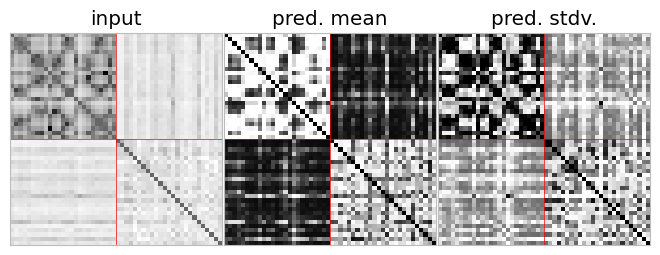

In [37]:
# make combined plot of pred. mean., pred. stdv. (for single test sample), and pred. stdv. vs error plot

def final_figure(label, input, edge_logits, n, test_sample_idx, label_block_sizes):
    print(f"Label {label.shape}, Input {input.shape}, Edge logits {edge_logits.shape}")
    edge_probs = jax.nn.sigmoid(edge_logits)
    input_adj = vec2adj(input, n=n).squeeze()
    
    # draw samples from the posterior preditive
    posterior_predictive_edge_samples = jax.random.bernoulli(jax.random.PRNGKey(0), edge_probs) + 0.0
    mean_edge_marginal_post_pred_estimate = np.array(posterior_predictive_edge_samples.mean(axis=0))
    std_edge_marginal_post_pred_estimate = np.array(posterior_predictive_edge_samples.std(axis=0))
    
    # add trailing dimension to mean and std
    mean_edge_marginal_post_pred_estimate = np.expand_dims(mean_edge_marginal_post_pred_estimate, 0)
    std_edge_marginal_post_pred_estimate = np.expand_dims(std_edge_marginal_post_pred_estimate, 0)
    error_l1 = np.abs(mean_edge_marginal_post_pred_estimate - label)
    
    #  add a leading singleton dimension to label
    label = jnp.expand_dims(label, 0)
    pos_error_l1 = error_l1[label == 1]
    neg_error_l1 = error_l1[label == 0]
    pos_uncertainty = std_edge_marginal_post_pred_estimate[label == 1]
    neg_uncertainty = std_edge_marginal_post_pred_estimate[label == 0]

    mean_adj_plot = vec2adj(mean_edge_marginal_post_pred_estimate.squeeze(), n=n).squeeze()
    std_adj_plot = vec2adj(std_edge_marginal_post_pred_estimate.squeeze(), n=n).squeeze()

    # plot label, mean, and std
    fig, axs = plt.subplots(1, 3) #3)

    axs[0].imshow(input_adj[test_sample_idx]/input_adj[test_sample_idx].max(), cmap='gray')
    axs[0].set_title('input')

    # left most plot is the mean
    axs[1].imshow(mean_adj_plot[test_sample_idx], cmap='gray')
    axs[1].set_title('pred. mean')

    # middle plot is the stdv
    axs[2].imshow(std_adj_plot[test_sample_idx]/std_adj_plot[test_sample_idx].max(), cmap='gray')
    axs[2].set_title('pred. stdv.')

    # Block sizes for the sector_graph_label_test_mat, used for drawing the block diagonals
    block_indices = np.cumsum([0] + label_block_sizes)
    # Drawing a thin line around the block diagonals for both subplots
    for ax, data_adj in zip(axs.flat, [input, mean_adj_plot, std_adj_plot]):
        for start, end in zip(block_indices[:-1], block_indices[1:]):
            # Draw a rectangle around the block diagonal
            rect = plt.Rectangle((start-0.5, start-0.5), end-start, end-start, 
                                 fill=False, color='red', linestyle='-', linewidth=0.5)
            ax.add_patch(rect)

    # remove the x and y ticks
    for ax in axs.flat:
        ax.set(xticks=[], yticks=[])

    # manually set the space between the subplots
    delta = 0.01
    space = 0.01
    plt.subplots_adjust(wspace=space, hspace=0, bottom=0.0, top=1, left=0.0, right=1.0)
    #plt.savefig(FIGURES_PATH + 'MNIST_uncertainty', dpi=1000, bbox_inches='tight', pad_inches=0.01)

#for i in range(len(test_label_vecs)):
#    print(i)
#    final_figure(test_label_vecs, test_distance_vecs, test_edge_logits, n, i)
final_figure(test_label_vecs, test_distance_vecs, test_edge_logits, n, 2, [25, 25])